# Tips for using colab Environment


## Click the following URL to load this notebook on Colab environment

* https://colab.research.google.com/github/ch6845/dynamic-cell-classifier/blob/master/3_DCC.ipynb

* You can use free GPUs from Google on Colab. (For more information, see https://colab.research.google.com/notebooks/welcome.ipynb)

## Enabling and testing the GPU
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down

## Load data
* Upload your data or, mount a storage to Colab virtual environment.
(For more information, see https://colab.research.google.com/notebooks/io.ipynb)

In [1]:
import datetime

import numpy as np
import pandas as pd

from scipy.io import mmread

import matplotlib.pyplot as plt

In [2]:
import os
os.__file__

'/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/os.py'

# load data

## expression data

In [3]:
exp_data=mmread('data/HumanLiver_extract/HumanLiver.data.counts.mm').toarray().astype(float)
with open('data/HumanLiver_extract/HumanLiver.data.col','r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
with open('data/HumanLiver_extract/HumanLiver.data.row','r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]
assert exp_data.shape==(len(exp_data_row),len(exp_data_col))

In [4]:
assert len(set(exp_data_row))==len(exp_data_row)
assert len(set(exp_data_col))==len(exp_data_col)

In [5]:
exp_data,exp_data.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), (20007, 8444))

In [6]:
exp_data_row[:5],exp_data_col[:5]

(['RP11-34P13.7', 'FO538757.2', 'AP006222.2', 'RP4-669L17.10', 'RP5-857K21.4'],
 ['P1TLH_AAACCTGAGCAGCCTC_1',
  'P1TLH_AAACCTGTCCTCATTA_1',
  'P1TLH_AAACCTGTCTAAGCCA_1',
  'P1TLH_AAACGGGAGTAGGCCA_1',
  'P1TLH_AAACGGGGTTCGGGCT_1'])

## cluster info 

In [7]:
exp_data_meta=pd.read_csv('data/HumanLiver_extract/HumanLiver.metadata.tsv',sep='\t')
exp_data_meta.head()

,total_counts,total_features,orig.ident,res.0.8,S.Score,G2M.Score,Phase,tSNE_1,tSNE_2
P1TLH_AAACCTGAGCAGCCTC_1,2943,1427,P1TLH,12,0.046089,0.000349,S,12.331038,4.044869
P1TLH_AAACCTGTCCTCATTA_1,10897,2522,P1TLH,17,-0.000357,0.009434,G2M,-10.186342,-50.465799
P1TLH_AAACCTGTCTAAGCCA_1,1914,1018,P1TLH,12,0.012811,-0.056561,S,15.618844,6.213892
P1TLH_AAACGGGAGTAGGCCA_1,5574,1798,P1TLH,10,-0.011324,-0.047102,G1,4.710776,10.386157
P1TLH_AAACGGGGTTCGGGCT_1,3700,1417,P1TLH,2,0.057467,-0.003861,S,-14.954216,19.197842


`clusterid_to_clustername` is used to convert integers in `res.0.8` to cell-type name

In [8]:
clusterid_to_clustername=pd.read_csv('data/HumanLiver_extract/HumanLiver.clusterid_to_clustername.tsv',sep='\t',header=None,index_col=0)
clusterid_to_clustername[1]=clusterid_to_clustername[1].str.replace(' ','_')
len(clusterid_to_clustername[1].unique()),

(11,)

# Panglao

In [9]:
markers_db=pd.read_csv("data/PanglaoDB_markers_27_Mar_2020.tsv.gz",sep='\t')
markers_db=markers_db[markers_db['species'].str.contains('Hs')].drop(columns='species')
markers_db['nicknames']=markers_db['nicknames'].astype(str)
markers_db.head()

markers_db.head()

marker_db_markerinfo=markers_db[~markers_db.duplicated(['official gene symbol'])][['official gene symbol','nicknames']]
#markers_db_markers=markers_db['official gene symbol'].unique()
#markers_db_markers_k
#list2=np.unique([j for i in markers_db['nicknames'].astype(str).apply(lambda x: x.split('|') if isinstance(x,str) else x) for j in i])

In [11]:
"""
with open('data/HumanLiver_extract/HumanLiver.data.row','r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]
marker_db_markerinfo_nicknames=np.unique([j for i in marker_db_markerinfo['nicknames'].astype(str).apply(lambda x: x.split('|') if isinstance(x,str) else x) for j in i])
exp_data_row_new=[]
exp_data_row_new_check=[]
for marker in exp_data_row:
    if marker in marker_db_markerinfo['official gene symbol'].values:
        exp_data_row_new.append(marker)
        exp_data_row_new_check.append(True)        
    elif marker in marker_db_markerinfo_nicknames:
        official_name=marker_db_markerinfo[(marker_db_markerinfo['nicknames']==marker)|
                                   (marker_db_markerinfo['nicknames'].str.startswith(marker+'|'))|
                                   (marker_db_markerinfo['nicknames'].str.endswith('|'+marker))|
                                   (marker_db_markerinfo['nicknames'].str.contains('|'+marker+'|',regex=False))]['official gene symbol'].values[0]
        if official_name in exp_data_row_new:
            #print('error')
            #exp_data_row_new.append(official_name)
            exp_data_row_new_check.append(False)            
        else:
            exp_data_row_new.append(marker)
            exp_data_row_new_check.append(True)
    else:
        exp_data_row_new.append(marker)
        exp_data_row_new_check.append(True)
exp_data_row=list(exp_data_row_new)
exp_data=exp_data[exp_data_row_new_check,:]
"""

'\nwith open(\'data/HumanLiver_extract/HumanLiver.data.row\',\'r\') as f: exp_data_row=[i.strip().strip(\'"\') for i in f.read().split()]\nmarker_db_markerinfo_nicknames=np.unique([j for i in marker_db_markerinfo[\'nicknames\'].astype(str).apply(lambda x: x.split(\'|\') if isinstance(x,str) else x) for j in i])\nexp_data_row_new=[]\nexp_data_row_new_check=[]\nfor marker in exp_data_row:\n    if marker in marker_db_markerinfo[\'official gene symbol\'].values:\n        exp_data_row_new.append(marker)\n        exp_data_row_new_check.append(True)        \n    elif marker in marker_db_markerinfo_nicknames:\n        official_name=marker_db_markerinfo[(marker_db_markerinfo[\'nicknames\']==marker)|\n                                   (marker_db_markerinfo[\'nicknames\'].str.startswith(marker+\'|\'))|\n                                   (marker_db_markerinfo[\'nicknames\'].str.endswith(\'|\'+marker))|\n                                   (marker_db_markerinfo[\'nicknames\'].str.contains(\'|\'+ma

In [12]:
#markers_db[markers_db['cell type'].str.contains('T')]

In [13]:
#markers_db[(markers_db['official gene symbol']=='FXDY2') |(markers_db['nicknames'].str.contains('FXDY2'))],'FXDY2' in exp_data_row

## Marker info

In [40]:
deg_poisson=pd.read_csv('data/HumanLiver_extract/HumanLiver.deg_poisson.tsv',sep='\t').iloc[:-1]

clustername_to_markers={}
for cluster in deg_poisson['cluster'].unique():
    deg_poisson_select=deg_poisson[deg_poisson['cluster']==cluster]
    #clustername_to_markers[cluster]=deg_poisson_select[deg_poisson_select['avg_logFC']>2]['gene'].values.tolist()
    #clustername_to_markers[cluster]=deg_poisson_select.sort'avg_logFC']>2]['gene'].values.tolist()
    #print(
    clustername_to_markers[cluster]=deg_poisson_select.sort_values('avg_logFC',ascending=False)[:30]['gene'].values.tolist()

In [15]:
cell_size_factor=pd.read_csv('data/analysis/size_factor_cluster.tsv',sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
#cell_size_factor=np.ones_like(cell_size_factor)
cell_size_factor.shape

(8444,)

In [16]:
#torch.cuda.

In [17]:
exp_data_col_patient=pd.Series(exp_data_col).str.slice(start=1,stop=2).astype(int).values
x_data_covariate=np.eye(len(np.unique(exp_data_col_patient)))[exp_data_col_patient-1]
x_data_intercept=np.array([np.ones(exp_data.shape[1])]).transpose()
x_data_null=np.concatenate([x_data_intercept,x_data_covariate[:,:]],axis=1)
x_data_null.shape

(8444, 6)

# Torch porting

In [18]:
# Asuume that the following variables are initialized

# Input


delta_min=2
B=10
LR=1e-1

# Optional
EM_ITER_MAX=20
M_ITER_MAX=10000

BATCH_SIZE=exp_data.shape[1]
NUM_WORKERS=0

LOWER_BOUND=1e-10
THETA_LOWER_BOUND=1e-20


Q_diff_tolerance=1e-4
LL_diff_tolerance=1e-4

In [19]:
import math
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [20]:
torch.set_default_dtype(torch.float64) 

In [21]:
device_cpu=torch.device("cpu")
device_cuda_list=[torch.device("cuda:{}".format(i)) for i in range(6)][::-1]

In [22]:
#from basic_tools import Cell_Dataset,Masked
class Masked_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, mask):
        #print('aaaa')
        output=input
        ctx.save_for_backward(input, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, mask = ctx.saved_tensors
        grad_input = grad_mask = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mul(mask)

        return grad_input, grad_mask
    
class Masked(nn.Module):    
    def __init__(self, mask):    
        super(Masked, self).__init__()
        
        self.mask = nn.Parameter(torch.Tensor(mask)==1, requires_grad=False)    
        
        
    def forward(self, input):
        return Masked_Function.apply(input, self.mask)

    def extra_repr(self):
        return 'mask={}'.format(self.mask.shape)  

In [23]:
import math
class NB_logprob(nn.Module):
    def __init__(self):
        super(NB_logprob,self).__init__()
        
    def forward(self,total_count,probs,value):
        
        #eps = torch.finfo(probs.dtype).eps
        #probs_clamped=probs.clamp(min=eps, max=1 - eps)        
        probs_clamped=probs
        logits=torch.log(probs_clamped) - torch.log1p(-probs_clamped)
        #logits=torch.log(probs_clamped)
        
        log_unnormalized_prob = (total_count * F.logsigmoid(-logits) +
                                 value * F.logsigmoid(logits))
        log_normalization = (-torch.lgamma(total_count + value) + torch.lgamma(1. + value) +
                             torch.lgamma(total_count))

        return log_unnormalized_prob - log_normalization
    
class Normal_logprob(nn.Module):
    def __init__(self):
        super(Normal_logprob,self).__init__()
        
    def forward(self,loc,scale,value):
    
        var = (scale ** 2)
        log_scale = torch.log(scale)
        
        
        #print(loc.shape,scale.shape,value.shape)
        return -((value - loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))    
        #return log_scale
        
class Poisson_logprob(nn.Module):
    def __init__(self):
        super(Poisson_logprob,self).__init__()
        
    def forward(self,rate,value):
        #rate=rate.clamp(min=1e-3)+(-1)/rate.clamp(max=-1e-5)
        
        return (rate.log() * value) - rate - (value + 1).lgamma()
    
class Dirichlet_logprob(nn.Module):
    def __init__(self):
        super(Dirichlet_logprob,self).__init__()
        
    def forward(self,concentration,value):
        
        return ((torch.log(value) * (concentration - 1.0)).sum(-1) +
                torch.lgamma(concentration.sum(-1)) -
                torch.lgamma(concentration).sum(-1))
    
        
NB_logprob=NB_logprob()        
normal_logprob=Normal_logprob()
poisson_logprob=Poisson_logprob()
dirichlet_logprob=Dirichlet_logprob()

In [24]:
class Cell_Dataset(Dataset):
    def __init__(self,Y,X,s):
        self.Y=Y
        self.X=X
        self.s=s
        
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self,idx):
        item= {"Y":self.Y[idx,:],"X":self.X[idx,:],"s":self.s[idx]}
        return item  

In [25]:
def run_EM():
    global gamma_new,Q_new,LL_new
    
    print('Start time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    with torch.no_grad():
        for batch_idx,batch in enumerate(cell_dataloader):
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)    
        gamma_fixed,_,LL_old=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
        _,Q_old,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')

    print(LL_old)
    print(Q_old)

    for em_idx in range(EM_ITER_MAX):#
        #optimizer = optim.Adam(model.parameters(),lr=0.1,eps=1e-3,betas=(0.9,0.999))
        LL_new=torch.zeros_like(LL_old)
        #optimizer = optim.Adam(model.parameters(),lr=LR)
        for batch_idx,batch in enumerate(cell_dataloader):
            # It is usually just one iteration(batch).
            # However, developer of cellAssign may have done this for extreme situation of larse sample size
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)

            #############
            #E-step
            ######### ####
            with torch.no_grad():
                gamma_new,_,_=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='E')

            #############
            #M-step
            #############
            for m_idx in range(M_ITER_MAX):#
            #for m_idx in range(20):#    
                optimizer.zero_grad()
                _,Q_new,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_new,mode='M')
                Q_new.backward()
                optimizer.step()
                
                #Constraint
                model.delta_log.data=model.delta_log.data.clamp(min=model.delta_log_min)
                model.NB_basis_a.data=model.NB_basis_a.data.clamp(min=0)

                if m_idx%20==0:
                    #print(sorted(model.delta_log.cpu().detach().numpy().flatten())[-10:])
                    Q_diff=(Q_old-Q_new)/torch.abs(Q_old)
                    Q_old=Q_new
                    print('M: {}, Q: {} Q_diff: {}'.format(m_idx,Q_new,Q_diff))    
                    if m_idx>0 and torch.abs(Q_diff)<Q_diff_tolerance:
                        print('M break')
                        break                
            #############
            #Look at LL
            #############
            with torch.no_grad():
                _,_,LL_temp=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
                LL_new+=LL_temp

        LL_diff=(LL_new-LL_old)/torch.abs(LL_old)
        LL_old=LL_new
        print('EM: {}, LL: {} LL_diff: {}'.format(em_idx,LL_new,LL_diff))
        if LL_diff<LL_diff_tolerance:
            print('EM break')
            break
    print('End time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))    
    return gamma_new,Q_new,LL_new

In [26]:
def run_EM_trick(model,optimizer,LL_diff_tolerance=LL_diff_tolerance,Q_diff_tolerance=Q_diff_tolerance):
    global gamma_new,LL_new
    
    print('Start time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    with torch.no_grad():
        for batch_idx,batch in enumerate(cell_dataloader):
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)    
        LL_old=model(batch_Y,batch_X,batch_s)
        Q_old=LL_old
    print(LL_old)

    for em_idx in range(EM_ITER_MAX):#
        #optimizer = optim.Adam(model.parameters(),lr=0.1,eps=1e-3,betas=(0.9,0.999))
        LL_new=torch.zeros_like(LL_old)
        #optimizer = optim.Adam(model.parameters(),lr=LR)
        for batch_idx,batch in enumerate(cell_dataloader):
            # It is usually just one iteration(batch).
            # However, developer of cellAssign may have done this for extreme situation of larse sample size
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)

            #############
            #M-step
            #############
            for m_idx in range(M_ITER_MAX):#
            #for m_idx in range(20):#    
                optimizer.zero_grad()
                Q_new=-model(batch_Y,batch_X,batch_s)
                Q_new.backward()
                optimizer.step()
                
                #Constraint
                model.delta_log.data=model.delta_log.data.clamp(min=model.delta_log_min)
                #model.NB_basis_a.data=model.NB_basis_a.data.clamp(min=0)

                if m_idx%20==0:
                    #print(sorted(model.delta_log.cpu().detach().numpy().flatten())[-10:])
                    Q_diff=(Q_old-Q_new)/torch.abs(Q_old)
                    Q_old=Q_new
                    print('M: {}, Q: {} Q_diff: {}'.format(m_idx,Q_new,Q_diff))    
                    if m_idx>0 and torch.abs(Q_diff)<(Q_diff_tolerance):
                        print('M break')
                        break
                        
                    with torch.no_grad():
                        gamma_new=Poisson_Function.apply(batch_Y,batch_X,batch_s,model.delta_log,model.beta,model.masked.mask,'gamma')                        
                        
                        
            #############
            #Look at LL
            #############
            with torch.no_grad():
                LL_temp=-Q_new
                LL_new+=LL_temp

        LL_diff=(LL_new-LL_old)/torch.abs(LL_old)
        LL_old=LL_new
        print('EM: {}, LL: {} LL_diff: {}'.format(em_idx,LL_new,LL_diff))
        if LL_diff<LL_diff_tolerance:
            print('EM break')
            break
    print('End time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))    
    

    return gamma_new,Q_new,LL_new

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions.negative_binomial import NegativeBinomial
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet

class Custom_Model(nn.Module):
    def __init__(self,Y,rho,X_col=5,delta_min=2,LOWER_BOUND=1e-10,THETA_LOWER_BOUND=1e-20):
        # Y,rho are needed for model parameter initialization
        super(Custom_Model, self).__init__()
        
        #rho
        self.masked=Masked(rho)
         
        #delta
        self.delta_log_min=np.log(delta_min) #
        self.delta_log=nn.Parameter(torch.Tensor(np.random.uniform(-2,2,size=rho.shape)),requires_grad=True) # (C,G)
        self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)

        #delta prior
        self.delta_log_mean=nn.Parameter(0*torch.ones(1),requires_grad=True)        
        self.delta_log_variance=nn.Parameter(1*torch.ones(1),requires_grad=True)           
        
        #beta
        Y_colmean=np.mean(Y,axis=0)
        beta_init=np.hstack([((Y_colmean-Y_colmean.mean())/np.std(Y_colmean)).reshape(-1,1),\
                     np.zeros((Y.shape[1],X_col-1))]).T
        self.beta=nn.Parameter(torch.Tensor(beta_init),requires_grad=True) # (P,G)
        
        #print(((np.mean(Y,axis=0)-np.mean(Y))/np.std(np.mean(Y,axis=0))).reshape(-1,1))
        #print(self.beta)
        
        #NB parameters
        self.NB_basis_mean=nn.Parameter(torch.Tensor(np.linspace(np.min(Y),np.max(Y),B)), requires_grad=False)
        self.NB_basis_a=nn.Parameter(torch.ones(B),requires_grad=True) # not consistent with paper.. hmm. strange...
        self.NB_basis_b=nn.Parameter((1/(2*((np.max(Y)-np.min(Y))/(B-1))**2))*torch.ones(B),requires_grad=False) # hmm... strange
        
        #theta
        self.theta_logit=nn.Parameter(torch.Tensor(np.random.normal(loc=0.,scale=1.,size=rho.shape[0])),requires_grad=True)
        
        # lower bounds
        self.LOWER_BOUND=LOWER_BOUND
        self.THETA_LOWER_BOUND=THETA_LOWER_BOUND
        
    def forward(self,Y,X,s,gamma_fixed=None,mode='E'):
        delta_log_masked=self.masked(self.delta_log) #(C,G)
        delta=torch.exp(delta_log_masked)*self.masked.mask
        
        X_beta_s=X.matmul(self.beta)+torch.log(s.view(-1, 1)) #(N,P)*(P,G) + (N,1) = (N,G)
        
        mu_log=X_beta_s.unsqueeze(dim=1).repeat(1,delta.shape[0],1)+delta #(N,1,G)+(C,G) = (N,C,G)
        
        mu=torch.exp(mu_log) # (N,C,G)
        
        #Y_extend=Y.view(Y.shape[0],1,Y.shape[1]).repeat(1,mu_log.shape[1],1) # (N,C,G)
        Y_extend=Y.unsqueeze(dim=1).repeat(1,mu_log.shape[1],1)
        
        # Negative Binomial
        phi_B=self.NB_basis_a*torch.exp(-self.NB_basis_b*(mu_log.unsqueeze(dim=3).repeat(1,1,1,B)-self.NB_basis_mean)**2) # (N,C,G,B)
        phi=torch.sum(phi_B,axis=3)+self.LOWER_BOUND
        Y_logprob=NB_logprob(total_count=phi,probs=(mu/(mu+phi)),value=Y_extend) # (N,C,G)
        
        # Normal
        #Y_logprob+=normal_logprob(loc=mu_log,scale=torch.ones(1).to(device),value=Y_extend) # (N,C,G)
        
        # Poisson
        #Y_logprob=poisson_logprob(rate=mu,value=Y_extend) # (N,C,G)

        theta_log=F.log_softmax(self.theta_logit,dim=0) # (C)          
        Y_logprob_reduce=torch.sum(Y_logprob,axis=2)+theta_log # (N,C)
        
        Y_logprob_reduce_reduce=torch.logsumexp(Y_logprob_reduce,dim=1).view(-1,1) # (N,1)
        
        gamma=torch.exp(Y_logprob_reduce-Y_logprob_reduce_reduce) # (N,C)

        if mode=='E':
            return gamma,None,None
        elif mode=='M' or mode=='LL':
            theta_log_prob=dirichlet_logprob(concentration=1e-2*torch.ones_like(theta_log),value=(torch.exp(theta_log)+self.THETA_LOWER_BOUND))
            #print(1e-2*torch.ones_like(theta_log))
            delta_log_prob=torch.sum(normal_logprob(loc=self.delta_log_mean*self.masked.mask,scale=self.delta_log_variance,value=delta_log_masked))            
            if mode=='M':
                Q=-torch.sum(gamma_fixed*Y_logprob_reduce) # (N,C) (N,C)
                Q=Q-theta_log_prob
                Q=Q-delta_log_prob
                return gamma,Q,None
            elif mode=='LL':      
                LL=torch.sum(Y_logprob_reduce_reduce) # product of likelihood(y_i)-> (1) 
                print(LL,theta_log_prob,delta_log_prob)
                LL=LL+theta_log_prob
                LL=LL+delta_log_prob
                return gamma,None,LL
        else:
            raise          

In [28]:
   
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions.negative_binomial import NegativeBinomial
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet


class Poisson_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Y, X, s, delta_log, beta, mask,to_return='LL'):

        with torch.no_grad():
            #mu=torch.exp((X.matmul(beta)+torch.log(s.view(-1, 1))).unsqueeze(dim=1).repeat(1,delta_log.shape[0],1)+torch.exp(delta_log))
            mu=torch.exp((X.matmul(beta)+torch.log(s.view(-1, 1))).unsqueeze(dim=1).repeat(1,delta_log.shape[0],1)+torch.exp(delta_log)*mask)
            Y_extend=Y.unsqueeze(dim=1).repeat(1,mu.shape[1],1)
            Y_logprob=poisson_logprob(rate=mu,value=Y_extend) # (N,C,G)
            Y_logprob_reduce=Y_logprob.sum(axis=2)
            
            Y_logprob_reduce_reduce=torch.logsumexp(Y_logprob_reduce,dim=1).view(-1,1)
            
            LL=torch.sum(Y_logprob_reduce_reduce)
            
            gamma=torch.exp(Y_logprob_reduce-Y_logprob_reduce_reduce)
            A=mu-Y.unsqueeze(dim=1)        
            
            #gradient
            grad_delta_log=(A*gamma.unsqueeze(dim=2)).sum(axis=0)
            grad_beta=(X.unsqueeze(dim=2)@gamma.unsqueeze(dim=1)@A).sum(axis=0)
        
            ctx.save_for_backward(grad_delta_log,grad_beta)
            
        if to_return=='LL':
            return LL
        else:
            return gamma
            

    @staticmethod
    def backward(ctx, grad_output):
        
        grad_Y = grad_X = grad_s = grad_delta_log = grad_beta = grad_mask=None
        grad_delta_log,grad_beta = ctx.saved_tensors

        return grad_Y, grad_X, grad_s, grad_delta_log, grad_beta, grad_mask

class Poisson_Function_Nomask(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Y, X, s, delta_log, beta, to_return='LL'):

        with torch.no_grad():
            #mu=torch.exp((X.matmul(beta)+torch.log(s.view(-1, 1))).unsqueeze(dim=1).repeat(1,delta_log.shape[0],1)+torch.exp(delta_log))
            mu=torch.exp((X.matmul(beta)+torch.log(s.view(-1, 1))).unsqueeze(dim=1).repeat(1,delta_log.shape[0],1)+torch.exp(delta_log))
            Y_extend=Y.unsqueeze(dim=1).repeat(1,mu.shape[1],1)
            Y_logprob=poisson_logprob(rate=mu,value=Y_extend) # (N,C,G)
            Y_logprob_reduce=Y_logprob.sum(axis=2)
            
            Y_logprob_reduce_reduce=torch.logsumexp(Y_logprob_reduce,dim=1).view(-1,1)
            
            LL=torch.sum(Y_logprob_reduce_reduce)
            
            gamma=torch.exp(Y_logprob_reduce-Y_logprob_reduce_reduce)
            A=mu-Y.unsqueeze(dim=1)        
            
            #gradient
            grad_delta_log=(A*gamma.unsqueeze(dim=2)).sum(axis=0)
            grad_beta=(X.unsqueeze(dim=2)@gamma.unsqueeze(dim=1)@A).sum(axis=0)
        
            ctx.save_for_backward(grad_delta_log,grad_beta)
            
        if to_return=='LL':
            return LL
        else:
            return gamma
            

    @staticmethod
    def backward(ctx, grad_output):
        
        grad_Y = grad_X = grad_s = grad_delta_log = grad_beta = None
        grad_delta_log,grad_beta = ctx.saved_tensors

        return grad_Y, grad_X, grad_s, grad_delta_log, grad_beta

class Custom_Model_Trick(nn.Module):
    def __init__(self,Y,rho,X_col=5,delta_min=2,LOWER_BOUND=1e-10,THETA_LOWER_BOUND=1e-20):
        # Y,rho are needed for model parameter initialization
        super(Custom_Model_Trick, self).__init__()
        
        #rho
        self.masked=Masked(rho)
         
        #delta
        self.delta_log_min=np.log(delta_min) #
        self.delta_log=nn.Parameter(torch.Tensor(np.random.uniform(-2,2,size=rho.shape)),requires_grad=True) # (C,G)
        self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)
          
        #beta
        Y_colmean=np.mean(Y,axis=0)
        beta_init=np.hstack([((Y_colmean-Y_colmean.mean())/np.std(Y_colmean)).reshape(-1,1),\
                     np.zeros((Y.shape[1],X_col-1))]).T
        self.beta=nn.Parameter(torch.Tensor(beta_init),requires_grad=True) # (P,G)
        
        # lower bounds
        self.LOWER_BOUND=LOWER_BOUND
        self.THETA_LOWER_BOUND=THETA_LOWER_BOUND
        
    def init_parameter(self,rho=None,Y=None,delta_min=None):
        if delta_min is not None:
            self.delta_log_min=np.log(delta_min) #
            self.delta_log.data=np.random.uniform(-2,2,size=self.delta_log.data.shape)
            self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)

        if rho is not None:
            self.masked.mask.data=(rho==1)
        
        if Y is not None:
            Y_colmean=np.mean(Y,axis=0)
            beta_init=np.hstack([((Y_colmean-Y_colmean.mean())/np.std(Y_colmean)).reshape(-1,1),\
                         np.zeros((Y.shape[1],X_col-1))]).T        
            self.beta.data=beta_init
        
    def forward(self,Y,X,s):
        delta_log_masked=self.masked(self.delta_log) #(C,G)
        #delta=torch.exp(delta_log_masked)*self.masked.mask
        
        LL=Poisson_Function.apply(Y,X,s,delta_log_masked,self.beta,self.masked.mask)

        return LL  
    
class Custom_Model_Trick_Nomask(nn.Module):
    def __init__(self,Y,rho,X_col=5,delta_min=2,LOWER_BOUND=1e-10,THETA_LOWER_BOUND=1e-20):
        # Y,rho are needed for model parameter initialization
        super(Custom_Model_Trick_Nomask, self).__init__()
         
        #delta
        self.delta_log_min=np.log(delta_min) #
        self.delta_log=nn.Parameter(torch.Tensor(np.random.uniform(-2,2,size=rho.shape)),requires_grad=True) # (C,G)
        self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)
          
        #beta
        Y_colmean=np.mean(Y,axis=0)
        beta_init=np.hstack([((Y_colmean-Y_colmean.mean())/np.std(Y_colmean)).reshape(-1,1),\
                     np.zeros((Y.shape[1],X_col-1))]).T
        self.beta=nn.Parameter(torch.Tensor(beta_init),requires_grad=True) # (P,G)
        
        # lower bounds
        self.LOWER_BOUND=LOWER_BOUND
        self.THETA_LOWER_BOUND=THETA_LOWER_BOUND
        
    def init_parameter(self,Y=None,delta_min=None):
        if delta_min is not None:
            self.delta_log_min=np.log(delta_min) #
            self.delta_log.data[:]=torch.Tensor(np.random.uniform(-2,2,size=self.delta_log.data.shape))
            self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)
        
        if Y is not None:
            Y_colmean=np.mean(Y,axis=0)
            beta_init=np.hstack([((Y_colmean-Y_colmean.mean())/np.std(Y_colmean)).reshape(-1,1),\
                         np.zeros((Y.shape[1],model.beta.shape[0]-1))]).T        
            self.beta.data[:]=torch.Tensor(beta_init)
        
    def forward(self,Y,X,s):
        
        LL=Poisson_Function_Nomask.apply(Y,X,s,self.delta_log,self.beta)

        return LL     

In [29]:
import time
print(time.time())

1589474135.1578166


In [52]:
device=device_cuda_list[0]#

In [ ]:



clustername_unique=list(clustername_to_markers.keys())
#exp_data_meta_clusterid_clusteridunique=clusterid_to_clustername.loc[exp_data_meta['res.0.8'].values][1].apply(lambda x: clustername_unique.index(x))

marker_unique=np.unique([j for i in list(clustername_to_markers.values()) for j in i])
marker_unique_exp_data_idx=[exp_data_row.index(marker) for marker in marker_unique]
marker_unique,len(marker_unique)


marker_onehot=np.array([np.sum(np.eye(len(marker_unique))[[marker_unique.tolist().index(marker) for marker in value]],axis=0) for key,value in clustername_to_markers.items()])
marker_onehot.shape
#marker_onehot.T

Y=exp_data[marker_unique_exp_data_idx].transpose().astype(float)
Y.shape




Y
s=cell_size_factor
X=x_data_null.copy()[:,[0,1,2]]
# 234 x
# 34 x
# 123 x
rho=marker_onehot


cell_dataset=Cell_Dataset(Y,X,s)
cell_dataloader=DataLoader(dataset=cell_dataset,shuffle=False,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)





#device=device_cpu
#model=Custom_Model(Y,rho,X_col=X.shape[1],delta_min=delta_min,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
model=Custom_Model_Trick(Y,rho,X_col=X.shape[1],delta_min=2,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
optimizer = optim.Adam(model.parameters(),lr=LR)#,betas=(0.92, 0.999))

gamma_value,Q_value,LL_value=run_EM_trick(model,optimizer,LL_diff_tolerance=LL_diff_tolerance,Q_diff_tolerance=Q_diff_tolerance)

In [53]:
clustername_unique=list(clustername_to_markers.keys())
#exp_data_meta_clusterid_clusteridunique=clusterid_to_clustername.loc[exp_data_meta['res.0.8'].values][1].apply(lambda x: clustername_unique.index(x))

marker_unique=np.unique([j for i in list(clustername_to_markers.values()) for j in i])
marker_unique_exp_data_idx=[exp_data_row.index(marker) for marker in marker_unique]
marker_unique,len(marker_unique)


marker_onehot=np.array([np.sum(np.eye(len(marker_unique))[[marker_unique.tolist().index(marker) for marker in value]],axis=0) for key,value in clustername_to_markers.items()])
marker_onehot.shape
#marker_onehot.T

Y=exp_data[marker_unique_exp_data_idx].transpose().astype(float)
Y.shape




Y
s=cell_size_factor
X=x_data_null.copy()[:,[0,1,2]]
# 234 x
# 34 x
# 123 x
rho=marker_onehot


cell_dataset=Cell_Dataset(Y,X,s)
cell_dataloader=DataLoader(dataset=cell_dataset,shuffle=False,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)





#device=device_cpu
#model=Custom_Model(Y,rho,X_col=X.shape[1],delta_min=delta_min,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
model=Custom_Model_Trick(Y,np.ones((rho.shape[0]*2,rho.shape[1])),X_col=X.shape[1],delta_min=0,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
optimizer = optim.Adam(model.parameters(),lr=LR)#,betas=(0.92, 0.999))

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in log


In [57]:
gamma_value,Q_value,LL_value=run_EM_trick(model,optimizer,LL_diff_tolerance=1e-1*LL_diff_tolerance,Q_diff_tolerance=1e-1*Q_diff_tolerance)

Start time: 2020-05-15 01:57:04
tensor(-7901649.3352, device='cuda:5')
M: 0, Q: 7901649.335226923 Q_diff: -2.0
M: 20, Q: 7899178.964972623 Q_diff: 0.00031263982359824497
M: 40, Q: 7898796.106311398 Q_diff: 4.846815889635848e-05
M: 60, Q: 7897633.230633693 Q_diff: 0.00014722188825403852
M: 80, Q: 7897257.633221857 Q_diff: 4.755822420047086e-05
M: 100, Q: 7896348.855936703 Q_diff: 0.00011507504596671265
M: 120, Q: 7896048.278131069 Q_diff: 3.806541619657608e-05
M: 140, Q: 7895648.447726684 Q_diff: 5.063677301623967e-05
M: 160, Q: 7895040.030430381 Q_diff: 7.705729305585793e-05
M: 180, Q: 7894376.694768531 Q_diff: 8.401929050304993e-05
M: 200, Q: 7894016.276143432 Q_diff: 4.565510857094363e-05
M: 220, Q: 7893433.737095898 Q_diff: 7.379501474986086e-05
M: 240, Q: 7892895.826326577 Q_diff: 6.814661239164707e-05
M: 260, Q: 7892421.401411183 Q_diff: 6.0107839484132144e-05
M: 280, Q: 7892714.667323036 Q_diff: -3.715791351441325e-05
M: 300, Q: 7893254.612277144 Q_diff: -6.841055034498645e-05
M:

KeyboardInterrupt: 

In [34]:
#clustername_to_markers

In [43]:
rho.shape

(22, 470)

In [ ]:
deg_poisson_select=deg_poisson[deg_poisson['cluster']==cluster]
#clustername_to_markers[cluster]=deg_poisson_select[deg_poisson_select['avg_logFC']>2]['gene'].values.tolist()
#clustername_to_markers[cluster]=deg_poisson_select.sort'avg_logFC']>2]['gene'].values.tolist()
#print(
clustername_to_markers[cluster]=deg_poisson_select.sort_values('avg_logFC',ascending=False)[:30]['gene'].

In [33]:
sample=list(clustername_to_markers_all.keys())
np.random.shuffle(sample)
sample_list=[sample[i:i+20]for i in range(0,len(sample),30)]

device=device_cuda_list[2]#

In [38]:
result_list=[]
for i in range(len(sample_list)):
    clustername_to_markers={i:clustername_to_markers_all[i] for i in sample_list[i]}


    clustername_unique=list(clustername_to_markers.keys())
    #exp_data_meta_clusterid_clusteridunique=clusterid_to_clustername.loc[exp_data_meta['res.0.8'].values][1].apply(lambda x: clustername_unique.index(x))

    marker_unique=np.unique([j for i in list(clustername_to_markers.values()) for j in i])
    marker_unique_exp_data_idx=[exp_data_row.index(marker) for marker in marker_unique]
    marker_unique,len(marker_unique)


    marker_onehot=np.array([np.sum(np.eye(len(marker_unique))[[marker_unique.tolist().index(marker) for marker in value]],axis=0) for key,value in clustername_to_markers.items()])
    marker_onehot.shape
    #marker_onehot.T

    Y=exp_data[marker_unique_exp_data_idx].transpose().astype(float)
    Y.shape




    Y
    s=cell_size_factor
    X=x_data_null.copy()[:,[0,1,2]]
    # 234 x
    # 34 x
    # 123 x
    rho=marker_onehot


    cell_dataset=Cell_Dataset(Y,X,s)
    cell_dataloader=DataLoader(dataset=cell_dataset,shuffle=False,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)




    
    #device=device_cpu
    #model=Custom_Model(Y,rho,X_col=X.shape[1],delta_min=delta_min,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
    model=Custom_Model_Trick(Y,rho,X_col=X.shape[1],delta_min=1,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
    optimizer = optim.Adam(model.parameters(),lr=LR)#,betas=(0.92, 0.999))
    
    gamma_value,Q_value,LL_value=run_EM_trick(model,optimizer,LL_diff_tolerance=1e+1*LL_diff_tolerance,Q_diff_tolerance=1e+1*Q_diff_tolerance)

    
    delta_result=(model.delta_log).detach().cpu().numpy()
    delta_mask=(model.masked.mask).detach().cpu().numpy()

    result_list.append([np.exp(delta_result[i])[delta_mask[i]] for i in range(model.delta_log.shape[0])])

    del model
    torch.cuda.empty_cache() 

NameError: name 'sample_list' is not defined

In [200]:
#delta_min

In [201]:
#36초 7415
#36초 7255
#38
#delta만 비슷
#theta만 


In [35]:
count_result=np.unique(np.argmax(gamma_new.cpu().numpy(),axis=1)[np.max(gamma_value.cpu().numpy(),axis=1)>0],return_counts=True)
count_result

NameError: name 'gamma_value' is not defined

In [115]:
np.sum(np.argmax(gamma_new.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique)

NameError: name 'exp_data_meta_clusterid_clusteridunique' is not defined

In [61]:
#model.delta_log
sample_list[i]

['Acinar cells',
 'Adipocyte progenitor cells',
 'Adipocytes',
 'Adrenergic neurons',
 'Airway epithelial cells',
 'Airway goblet cells',
 'Airway smooth muscle cells',
 'Alpha cells',
 'Alveolar macrophages',
 'Anterior pituitary gland cells',
 'Astrocytes',
 'B cells',
 'B cells memory',
 'B cells naive',
 'Basal cells',
 'Basophils',
 'Bergmann glia',
 'Beta cells',
 'Cajal-Retzius cells',
 'Cardiac stem and precursor cells']

In [62]:
count_result=np.unique(np.argmax(gamma_new.cpu().numpy(),axis=1)[np.max(gamma_new.cpu().numpy(),axis=1)>0.95],return_counts=True)
count_result

(array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),
 array([  88,  253,    8,  129,   26,   26,  161,  535,   22,  280,  129,
         126,   10, 2856,  706,  201,   61,   25,   14]))

In [52]:
#np.unique?

In [59]:
delta_result=(model.delta_log).detach().cpu().numpy()
delta_mask=(model.masked.mask).detach().cpu().numpy()

[(np.sum(np.exp(delta_result[i])[delta_mask[i]]>1.1),np.sum(delta_mask[i])) for i in range(model.delta_log.shape[0])]

[(11, 25),
 (4, 18),
 (49, 101),
 (0, 7),
 (1, 4),
 (13, 20),
 (1, 3),
 (4, 28),
 (13, 21),
 (2, 20),
 (3, 54),
 (33, 93),
 (19, 60),
 (15, 62),
 (9, 47),
 (10, 67),
 (3, 32),
 (1, 35),
 (10, 61),
 (2, 15)]

In [204]:
count_result=np.unique(np.argmax(gamma_new.cpu().numpy(),axis=1)[np.max(gamma_value.cpu().numpy(),axis=1)>0.95],return_counts=True)
count_result

(array([0, 2, 3, 4, 6, 7, 8, 9]),
 array([ 331,  858,  660,  545,  737,  591,  405, 1002]))

In [110]:
count_result=np.unique(np.argmax(gamma_new.cpu().numpy(),axis=1)[np.max(gamma_value.cpu().numpy(),axis=1)>0.95],return_counts=True)
count_result

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 160, 2127,  202,  620,  993,  183,  995,   21,  349,   92]))

In [69]:
count_result=np.unique(np.argmax(gamma_value.cpu().numpy(),axis=1),return_counts=True)
count_result

(array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 323,  219, 1065, 1089,  690, 1231,   43,  642,  108, 3034]))

In [65]:
pd.Series(count_result[1],index=count_result[0]).sort_values(ascending=False).iloc[:int(len(count_result[1])/2)].index#sample


Int64Index([4, 3, 8, 6, 2], dtype='int64')

In [209]:
sample_list[1]#,clustername_to_markers

['T regulatory cells',
 'Mast cells',
 'Pancreatic progenitor cells',
 'Myocytes',
 'T follicular helper cells',
 'Basal cells',
 'Salivary mucous cells',
 'Osteoblasts',
 'Tuft cells',
 'Meningeal cells']

In [174]:
#torch.cuda.empty_cache() 
delta_mask[i]


In [207]:
#len(marker_unique),model.delta_log.shape
delta_result=(model.delta_log).detach().cpu().numpy()
delta_mask=(model.masked.mask).detach().cpu().numpy()

[np.sum(np.exp(delta_result[i])[delta_mask[i]]>1)>0.5*np.sum(delta_mask[i]) for i in range(model.delta_log.shape[0])]
    
    #print()
    #print(delta_result[i])

[False, False, False, False, False, False, False, True, False, False]

In [148]:
#clustername_to_markers

In [128]:
np.unique((model.delta_log.exp()*model.masked.mask).flatten().detach().cpu().numpy())


array([0.        , 1.        , 1.01705394, 1.05140764, 1.05902241,
       1.06287762, 1.07418664, 1.09262019, 1.0984212 , 1.11171978,
       1.17214326, 1.19213079, 1.19931376, 1.2193816 , 1.35707768,
       1.36633845, 1.37411312, 1.38885142, 1.43920617, 1.44979505,
       1.53024721, 1.53890938, 1.54409717, 1.61957507, 1.6515682 ,
       1.65201037, 1.72661349, 1.7876232 , 1.80270232, 1.862107  ,
       2.01291484, 2.13941853, 2.18844543, 2.19547693, 2.2401988 ,
       2.26146794, 2.29629072, 2.33257786, 2.37436227, 2.39201047,
       2.49416531, 2.49544017, 2.56217189, 2.63279563, 2.71765592,
       2.73479599, 2.73865551, 2.81093579, 2.81564503, 2.91555019,
       2.96517985, 3.02915137, 3.03963589, 3.1280477 , 3.17227111,
       3.23183202, 3.24946464, 3.3146952 , 3.32496355, 3.33735308,
       3.35870563, 3.36922985, 3.44365154, 3.48248092, 3.51727762,
       3.56530565, 3.6044045 , 3.78771508, 3.85561203, 3.97988118,
       3.98811954, 4.01076867, 4.04860921, 4.1095308 , 4.13075

In [211]:
np.argmax(gamma_value.cpu().numpy(),axis=1)[np.max(gamma_value.cpu().numpy(),axis=1)>0.95].shape

(6323,)

In [235]:
np.unique(exp_data_meta_clusterid_clusteridunique,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 119,  129, 3501,  844,   37, 1192,  961,  569,  488,  511,   93]))

In [128]:
#
pd.DataFrame([[np.sum((np.argmax(gamma_new.cpu().numpy(),axis=1)==i)[exp_data_meta_clusterid_clusteridunique==i]) for i in np.unique(exp_data_meta_clusterid_clusteridunique)],
 [np.sum(exp_data_meta_clusterid_clusteridunique==i) for i in np.unique(exp_data_meta_clusterid_clusteridunique)]],
columns=list(clustername_to_markers.keys())[:-1],
index=['correctly assigned cell','number of cells']
).T

,correctly assigned cell,number of cells
Cholangiocytes,117,119
Mature_B_cells,106,129
Hepatocytes,3478,3501
LSECs,710,844
Hepatic_Stellate_Cells,37,37
Macrophages,1144,1192
ab_T_cells,774,961
gd_T_cells,444,569
NK_cells,476,488
Plasma_cells,501,511


In [59]:
np.unique(plot_value)

array([ 3, 12, 18, 29, 36, 39, 42])

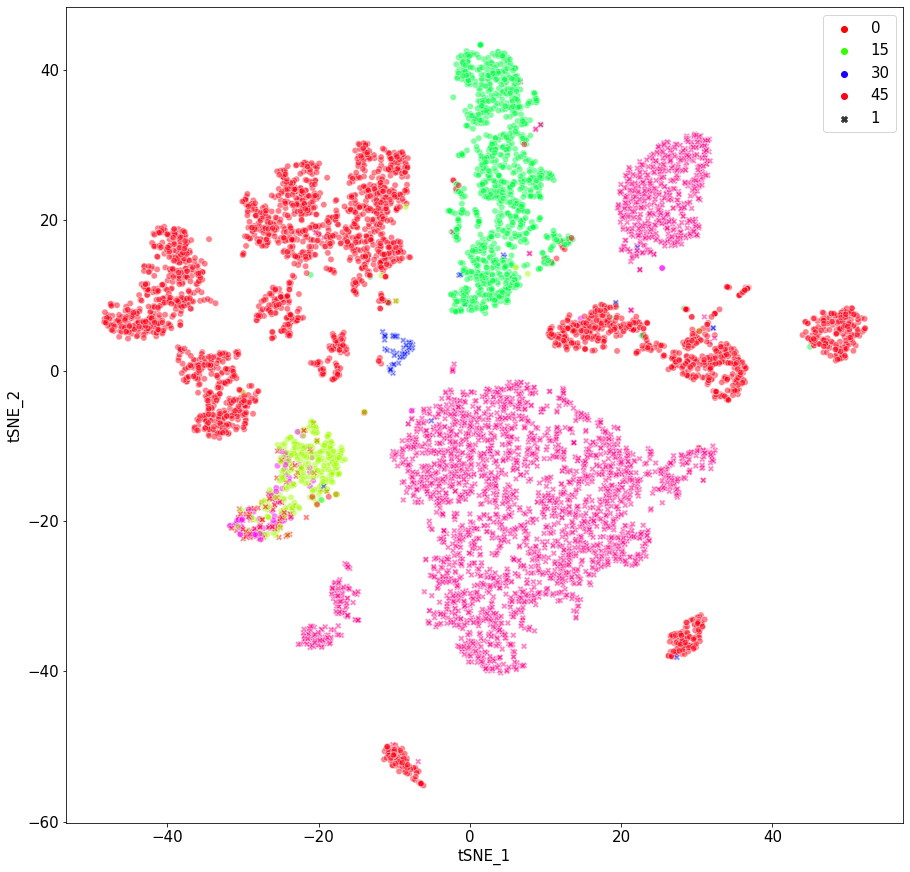

In [58]:
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["font.size"] = 15
plt.rcParams['font.family']='Arial'


plot_value=np.argmax(gamma_new.cpu().numpy(),axis=1)
#np.argmax(Poisson_Function_Nomask.apply(batch_Y,batch_X,batch_s,model.delta_log,model.beta,"gamma").detach().cpu().numpy(),axis=1)

sns.scatterplot(x="tSNE_1", y="tSNE_2",hue=plot_value,style=np.array((list(range(0,2))*30))[plot_value],
                data=exp_data_meta,s=40,palette=plt.cm.hsv,alpha=0.5)#,linewidth=0.3)

In [61]:
np.median(np.array(time_list).T[5])

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
# 0.000138 zero grad 
# 0.047395 front 
# 0.057923 backward
# 0.001740 step

(array([ 1.,  2.,  0.,  1.,  1.,  0.,  1.,  0., 61., 27.]),
 array([0.00071716, 0.00083199, 0.00094681, 0.00106163, 0.00117645,
        0.00129128, 0.0014061 , 0.00152092, 0.00163574, 0.00175056,
        0.00186539]),
 <a list of 10 Patch objects>)

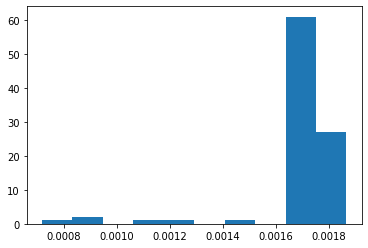

In [60]:
plt.hist(np.array(time_list).T[4])

In [ ]:
#np.isnan(M_get),M_get.shape

rho
#7363 7294 7367

In [146]:
7363/8444,7600/8444

(0.8719801042160114, 0.9000473709142587)

In [45]:
sum(np.argmax(gamma_new.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values),\

(7630,)

In [144]:
rho.shape

(12, 55)

In [90]:
#M_true.shape,
from scipy.stats import pearsonr
#M_get=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,np.argmax(gamma_new.cpu().numpy(),axis=1)==i],axis=1) for i in sorted(np.unique(np.argmax(gamma_new.cpu().numpy(),axis=1)))])
M_get=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,np.argmax(gamma_new.cpu().numpy(),axis=1)==i],axis=1) for i in range(rho.shape[0])])
M_get=np.nan_to_num(M_get,1)
type_mapping=[np.argmin([pearsonr(M_get[i],M_true[j])[1] for j in range(M_true.shape[0])]) for i in range(M_get.shape[0])]
sum(pd.Series(type_mapping)[np.argmax(gamma_value.cpu().numpy(),axis=1)].values==exp_data_meta_clusterid_clusteridunique.values)

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


7478

In [68]:
len(type_mapping)

21

range(0, 24)

In [69]:
rho.shape

(24, 63)

In [61]:
pd.Series(type_mapping)[np.argmax(gamma_value.cpu().numpy(),axis=1)].values.shape,exp_data_meta_clusterid_clusteridunique.values.shape

((8444,), (8444,))

In [64]:
np.unique(exp_data_meta_clusterid_clusteridunique.values),M_true.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), (11, 63))

In [52]:
delta_min

0

In [59]:
model.delta_log_min

-inf

In [93]:
model.delta_log.exp()

tensor([[5.5438, 6.8677, 6.4499,  ..., 6.0781, 8.0561, 6.3932],
        [6.3569, 6.0225, 6.1163,  ..., 6.1911, 5.7865, 6.9426],
        [6.3507, 5.1697, 5.0077,  ..., 5.5911, 5.8916, 5.6769],
        ...,
        [5.9142, 9.2594, 5.8219,  ..., 5.5893, 5.2697, 5.8865],
        [5.0248, 9.6543, 3.7499,  ..., 6.7895, 3.3872, 4.8630],
        [6.0585, 5.9672, 6.1915,  ..., 6.0775, 6.9236, 5.9648]],
       device='cuda:4', grad_fn=<ExpBackward>)

In [92]:
(model.delta_log.exp()[model.masked.mask]).flatten().min()

tensor(2.5065, device='cuda:4', grad_fn=<MinBackward1>)

(96,)

In [30]:
model=Custom_Model(Y,rho,X_col=X.shape[1],delta_min=delta_min,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)

/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


In [54]:
[cell_dataset[:]['Y'].shape,cell_dataset[:]['X'].size,cell_dataset[:]['s'].size]

[(8444, 63), 33776, 8444]

In [58]:
summary?

Signature: summary(model, input_size, batch_size=-1, device='cuda')
Docstring: <no docstring>
File:      ~/tools/miniconda3/envs/pytorch/lib/python3.6/site-packages/torchsummary/torchsummary.py
Type:      function


In [60]:
device

device(type='cuda', index=5)

In [62]:
from torchsummary import summary
summary(model,input_size=[cell_dataset[:]['Y'].shape,cell_dataset[:]['X'].shape,cell_dataset[:]['s'].shape],device='cuda')

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'mat2' in call to _th_mm

In [31]:
for name,param in model.named_parameters():
    print(name,param.size())

delta_log torch.Size([12, 63])
delta_log_mean torch.Size([1])
delta_log_variance torch.Size([1])
beta torch.Size([4, 63])
NB_basis_mean torch.Size([10])
NB_basis_a torch.Size([10])
NB_basis_b torch.Size([10])
theta_logit torch.Size([12])
masked.mask torch.Size([12, 63])


In [48]:
for batch_idx,batch in enumerate(cell_dataloader):
    # It is usually just one iteration(batch).
    # However, developer of cellAssign may have done this for extreme situation of larse sample size
    batch_Y=batch['Y'].to(device)
    batch_X=batch['X'].to(device)
    batch_s=batch['s'].to(device)

Start time: 2020-05-03 13:35:28
tensor(-7669628.7273, device='cuda:5') tensor(-19.1671, device='cuda:5') tensor(-1178.8088, device='cuda:5')
tensor(-7670826.7032, device='cuda:5')
tensor(7671773.7737, device='cuda:5')
M: 0, Q: 7671773.7736541815 Q_diff: 0.0
M: 20, Q: 2566880.1658998225 Q_diff: 0.6654124272127515
M: 40, Q: 2049999.058519762 Q_diff: 0.20136549974036955
M: 60, Q: 1881904.480737453 Q_diff: 0.08199739267377253
M: 80, Q: 1805504.3614400132 Q_diff: 0.040597235449219705
M: 100, Q: 1761565.7056747677 Q_diff: 0.024335945513973365
M: 120, Q: 1733824.8860063814 Q_diff: 0.015747820009790803
M: 140, Q: 1715936.6013248402 Q_diff: 0.010317238393517503
M: 160, Q: 1704009.9663510057 Q_diff: 0.006950510272131375
M: 180, Q: 1695831.3038760908 Q_diff: 0.004799656478787409
M: 200, Q: 1690110.1844792143 Q_diff: 0.00337363709692115
M: 220, Q: 1686048.270426146 Q_diff: 0.0024033427467451715
M: 240, Q: 1683130.947574422 Q_diff: 0.0017302724381589873
M: 260, Q: 1681017.1755881426 Q_diff: 0.00125

In [32]:
# Total 8444 cells
#NB              7640 LL: -271628 90sec 9iters
#NB(old markers) 7362 LL: -241538 90sec 13iters
#Poisson         7300 LL: -1116555 40sec 9iters 
#Normal          3369  LL: -783656280 doesn't_converge
#

In [54]:
#model.delta_log_min
exp_data_col_patient

array([1, 1, 1, ..., 5, 5, 5])

In [82]:
pd.DataFrame(np.array(np.unique(exp_data_meta_clusterid_clusteridunique.values[exp_data_col_patient==3],return_counts=True)))

,0,1,2,3,4,5,6,7,8
0,0,2,3,4,5,6,7,9,10
1,41,2621,156,24,244,2,1,29,9


In [84]:
#pd.DataFrame([np.unique(exp_data_meta_clusterid_clusteridunique.values[exp_data_col_patient==i],return_counts=True) for i in range(1,6)]).T
pd.concat([pd.DataFrame(np.array(np.unique(exp_data_meta_clusterid_clusteridunique.values[exp_data_col_patient==i],return_counts=True))).T.set_index(0) for i in range(1,6)],axis=1).fillna(0).astype(int)

,1,1,1,1,1
0,,,,,
0,8,23,41,13,34
1,7,7,0,34,81
2,96,629,2621,43,112
3,212,85,156,151,240
4,8,0,24,2,3
5,283,123,244,294,248
6,275,1,2,305,378
7,82,5,1,192,289
8,92,0,0,199,197


In [ ]:
#1,2 7607
# 7639
#1,2,4 7663
# 4485

#3 7600개
#2 7600개
#0  (1이상)

In [33]:
full0=pd.read_csv('data/analysis/cellassign_fit.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full1=pd.read_csv('data/analysis/cellassign_fit_full.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full2=pd.read_csv('data/analysis/cellassign_fit_full2.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full3=pd.read_csv('data/analysis/cellassign_fit_full3.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()

In [34]:
sum(np.argmax(full0,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full1,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full2,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full3,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(test3,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(gamma_new.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values),\

NameError: name 'test3' is not defined

In [ ]:
np.unique(exp_data_meta_clusterid_clusteridunique.values,return_counts=True)

In [35]:
np.unique(np.argmax(gamma_value.cpu().numpy(),axis=1),return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 125,  115, 3558,  741,   50, 1177,  602,  750,  664,  539,  121,
           2]))

In [36]:
dict(model.named_parameters())

{'delta_log': Parameter containing:
 tensor([[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          0.9312, 0.6931, 0.6931, 1.4206, 1.5949, 0.6931, 0.6931, 0.6931, 0.6931,
          1.6822, 1.9177, 1.8566, 0.6931, 0.6931, 0.6931, 1.5274, 0.6931, 1.6235,
          1.5616, 1.5839, 1.7507, 0.6931, 1.9307, 0.6931, 1.2182, 1.7909, 0.6931,
          0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 1.5505, 1.8670, 1.9099,
          1.8641, 1.5157, 1.7668, 1.7909, 0.6931, 1.8040, 0.6931, 0.6931, 0.6931,
          0.6931, 1.9931, 1.5128, 1.6299, 1.7888, 1.3055, 2.1360, 0.6931, 0.6931],
         [0.6931, 0.6931, 0.6931, 1.1388, 1.8762, 1.5920, 0.8309, 1.0070, 0.6931,
          1.3236, 1.3432, 0.9883, 0.6931, 0.6931, 0.6931, 0.8321, 0.6931, 1.9308,
          0.6931, 1.8264, 0.6931, 1.1021, 1.2913, 0.6931, 0.6931, 0.6931, 0.6931,
          0.6931, 1.2296, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
          1.7357, 1.8895, 1.8848, 0.6931, 0.6931, 1.1758, 0.6

In [ ]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
with torch.no_grad():
    for batch_idx,batch in enumerate(cell_dataloader):
        batch_Y=batch['Y'].to(device)
        batch_X=batch['X'].to(device)
        batch_s=batch['s'].to(device)    
    gamma_fixed,_,LL_old=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
    _,Q_old,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')
    
print(LL_old)
print(Q_old)


from torchviz import make_dot, make_dot_from_trace

make_dot(model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')[1],params=dict(model.named_parameters()))

In [ ]:

def run_EM():
    global gamma_new,Q_new,LL_new
    
    print('Start time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    with torch.no_grad():
        for batch_idx,batch in enumerate(cell_dataloader):
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)    
        gamma_fixed,_,LL_old=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
        _,Q_old,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')

    print(LL_old)
    print(Q_old)
    
    global time_list
    time_list=[]
    
    for em_idx in range(EM_ITER_MAX):#
        #optimizer = optim.Adam(model.parameters(),lr=0.1,eps=1e-3,betas=(0.9,0.999))
        LL_new=torch.zeros_like(LL_old)
        #optimizer = optim.Adam(model.parameters(),lr=LR)
        for batch_idx,batch in enumerate(cell_dataloader):
            # It is usually just one iteration(batch).
            # However, developer of cellAssign may have done this for extreme situation of larse sample size
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)

            #############
            #E-step
            ######### ####
            with torch.no_grad():
                gamma_new,_,_=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='E')

            #############
            #M-step
            #############
            for m_idx in range(M_ITER_MAX):#
                temp_list=[]
                temp_list.append(time.time());start_time=time.time()
            
                optimizer.zero_grad()
                temp_list.append(time.time()-start_time);start_time=time.time()
                
                
                _,Q_new,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_new,mode='M')
                temp_list.append(time.time()-start_time);start_time=time.time()
                Q_new.backward()
                temp_list.append(time.time()-start_time);start_time=time.time()
                
                optimizer.step()
                temp_list.append(time.time()-start_time);start_time=time.time()
                time_list.append(temp_list)
                
                #Constraint
                model.delta_log.data=model.delta_log.data.clamp(min=model.delta_log_min)
                model.NB_basis_a.data=model.NB_basis_a.data.clamp(min=0)

                if m_idx%20==0:
                    #print(sorted(model.delta_log.cpu().detach().numpy().flatten())[-10:])
                    Q_diff=(Q_old-Q_new)/torch.abs(Q_old)
                    Q_old=Q_new
                    print('M: {}, Q: {} Q_diff: {}'.format(m_idx,Q_new,Q_diff))    
                    if m_idx>0 and torch.abs(Q_diff)<Q_diff_tolerance:
                        print('M break')
                        break                
            #############
            #Look at LL
            #############
            with torch.no_grad():
                _,_,LL_temp=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
                LL_new+=LL_temp

        LL_diff=(LL_new-LL_old)/torch.abs(LL_old)
        LL_old=LL_new
        print('EM: {}, LL: {} LL_diff: {}'.format(em_idx,LL_new,LL_diff))
        if LL_diff<LL_diff_tolerance:
            print('EM break')
            break
    print('End time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))    
    return gamma_new,Q_new,LL_new